# First deep learning approach second challenge

In [1]:
import sys
import os
sys.path.append(os.path.abspath("../code/")) #Add parent directory
from modules.utils import set_seed

SEED = 42
set_seed(SEED)

# Libraries

In [2]:
import torch
import numpy as np
from modules.data_loader import get_data_loaders
from modules.efficientnet_v2_model import SkinLesionClassifier_EfficientNetV2M
from modules.efficientnet_B7 import SkinLesionClassifier_EfficientNetB7
from modules.train import train_model
from modules.utils import calculate_accuracy
from modules.visualize_aug import visualize_dataloader
from modules.plot_losses import plot_losses

# Connect to GPU

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

True
NVIDIA GeForce RTX 4060 Laptop GPU
Device: cuda


# Folder paths

In [4]:
tri_class_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\Tri".replace("\\","/")

train_dir = os.path.join(tri_class_path,"train/train").replace("\\","/")
val_dir = os.path.join(tri_class_path,"val/val").replace("\\", "/")

In [5]:
train_dir

'C:/Users/User/Desktop/UDG_old_pc/UDG/Subjects/Computer_Aided_Diagnosis/Labs/Datasets/Tri/train/train'

# Load data

In [6]:
batch_size = 32
train_loader, val_loader, test_loader = get_data_loaders(train_dir, val_dir, batch_size, seed = SEED)

Train set size: 5082
Validation set size: 635
Test set size: 635


In [7]:

# Check the number of classes
num_classes = len(train_loader.dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Classes: {train_loader.dataset.classes}")

Number of classes: 3
Classes: ['bcc', 'mel', 'scc']


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


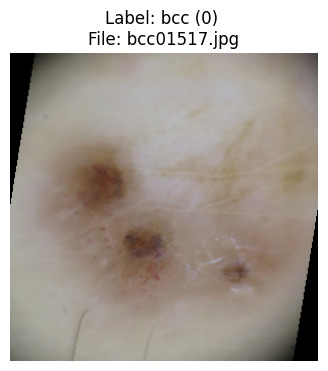

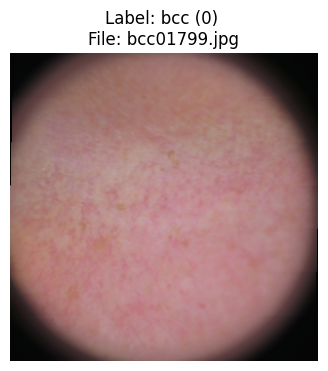

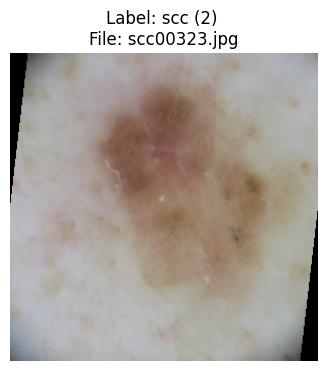

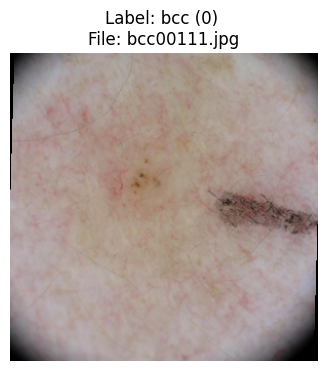

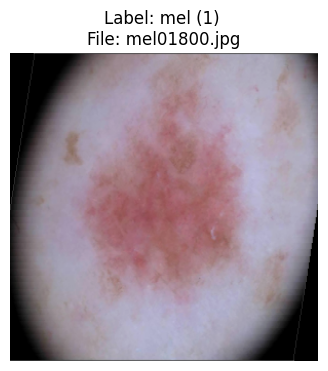

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(train_loader, mean, std, 5)

# Initialize model

In [9]:
#Initialize model
model = SkinLesionClassifier_EfficientNetB7(num_classes=3)
model

SkinLesionClassifier_EfficientNetB7(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tr

## Loss and optimizerv

Recommended settings for *scheduler*:
* mode='min' (to minimize validation loss).
* patience=3 (adjust based on how quickly your model stabilizes).
* factor=0.1 (reduce the learning rate by 10x when triggered).

In [10]:
num_epochs = 30
learning_rate = 1e-3
criterion = torch.nn.CrossEntropyLoss() #tHE OTHER ONE EXPECTS THE INPUT TO BE PASSED THROUGH A LOGIT BEFORE
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=1e-4)


#scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)
#Other schedulers
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', patience = 3, factor = 0.1)

## Train the model

Some possible things to fix regarding the small fluctations:
 1) Learning rate: if it is too high, it could cause instability in optimization
 2) Validation Data Variance: Some inherit noise
 3) Optimization

# Generalization GAP

Best model saved with val kappa: 0.6633 at epoch 1
Epoch 1 / 30 Training Loss: 0.5505 Validation Loss: 1.5070 Validation Kappa: 0.6633 LR: 0.0010000000
Epoch 2 / 30 Training Loss: 0.4090 Validation Loss: 1.0155 Validation Kappa: 0.6411 LR: 0.0010000000
Best model saved with val kappa: 0.7978 at epoch 3
Epoch 3 / 30 Training Loss: 0.3310 Validation Loss: 0.3836 Validation Kappa: 0.7978 LR: 0.0010000000
Epoch 4 / 30 Training Loss: 0.2793 Validation Loss: 0.3306 Validation Kappa: 0.7626 LR: 0.0010000000
Best model saved with val kappa: 0.8341 at epoch 5
Epoch 5 / 30 Training Loss: 0.2156 Validation Loss: 0.2945 Validation Kappa: 0.8341 LR: 0.0010000000
Epoch 6 / 30 Training Loss: 0.1855 Validation Loss: 0.3071 Validation Kappa: 0.8123 LR: 0.0010000000
Epoch 7 / 30 Training Loss: 0.1768 Validation Loss: 0.4189 Validation Kappa: 0.7195 LR: 0.0010000000
Epoch 8 / 30 Training Loss: 0.1571 Validation Loss: 0.4310 Validation Kappa: 0.7345 LR: 0.0010000000
Epoch 9 / 30 Training Loss: 0.1389 Vali

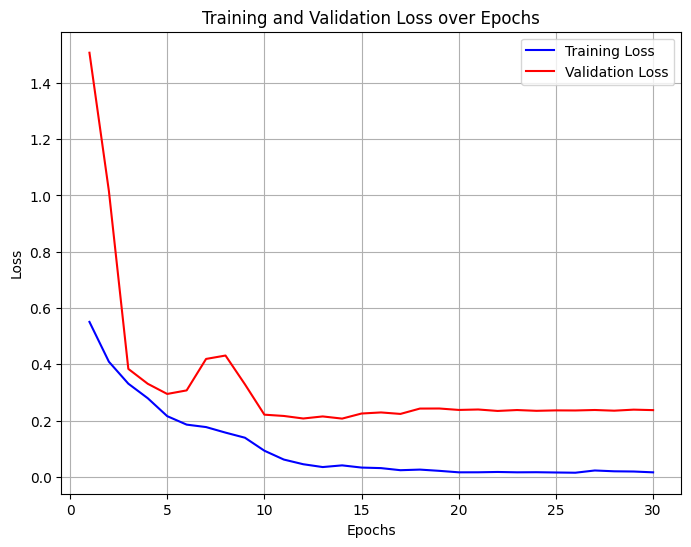

In [11]:
model, train_losses, val_losses = train_model(model,  train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, save_path ="tri_class_best_model_efficientB7_1_ReducePlatAdamW_4layers_30epochs.pth")
plot_losses(train_losses, val_losses)

# Test on the partitioned validation set

In [15]:
model_best_res = SkinLesionClassifier_EfficientNetB7(num_classes=3)
model_path = "tri_class_best_model_efficientB7_1_ReducePlatAdamW_4layers_30epochs.pth"
check_point = torch.load(model_path, map_location=device)
model_best_res.load_state_dict(check_point["model_state_dict"])

model_best_res.to(device)
model_best_res.eval()

C:\Users\User\AppData\Local\Temp\ipykernel_20584\3477424276.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  check_point = torch.load(model_path, map_location=device)


SkinLesionClassifier_EfficientNetB7(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=Tr

In [14]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, cohen_kappa_score
import numpy as np

# Initialize lists for predictions and labels
all_preds = []
all_labels = []

# Ensure the model is in evaluation mode
model_best_res.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels, _ in test_loader:
        # Move data to the appropriate device (e.g., GPU or CPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_best_res(inputs)

        # Convert logits to probabilities
        probabilities = torch.sigmoid(outputs)  # Works for BCEWithLogitsLoss

        # Convert probabilities to binary predictions (0 or 1)
        predictions = (probabilities > 0.5).float()  # Threshold at 0.5

        # Collect predictions and labels
        all_preds.extend(predictions.cpu().numpy())  # Convert to NumPy for compatibility
        all_labels.extend(labels.cpu().numpy())  # Convert to NumPy

# Convert lists to NumPy arrays
all_preds = np.array(all_preds).flatten()  # Flatten to ensure 1D array
all_labels = np.array(all_labels).flatten()  # Flatten to ensure 1D array

# Generate confusion matrix and metrics
cm = confusion_matrix(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)
kappa = cohen_kappa_score(all_labels, all_preds)  # Calculate kappa score

print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa Score: {kappa:.4f}")
print(classification_report(all_labels, all_preds))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title("Confusion Matrix")
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [635, 1905]

# Prediction over real test set and csv creation

In [33]:
from modules.data_loader import get_data_loader_test


Type of images: <class 'torch.Tensor'>
Type of labels: <class 'torch.Tensor'>
Type of paths: <class 'tuple'>


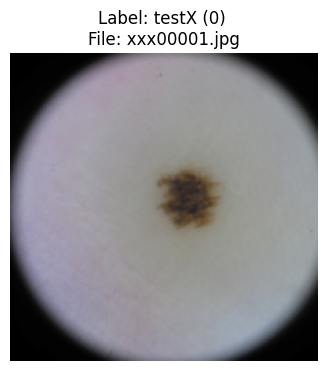

In [40]:
test_real_path = fr"C:\Users\User\Desktop\UDG_old_pc\UDG\Subjects\Computer_Aided_Diagnosis\Labs\Datasets\test_without_changes".replace("\\","/")

test_real_loader = get_data_loader_test(test_real_path, batch_size=1)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
visualize_dataloader(test_real_loader, mean, std, 1)

# Make predictions

In [41]:
import pandas as pd
#Check which model are you going to really use
model_best_res.eval()

predictions = []
filenames = []

with torch.no_grad():
    for inputs, _, paths in test_real_loader:
        file_name = os.path.basename(paths[0])
        
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy() #binary probs

        binary_predictions = (probabilities > 0.5).astype(int)

        if isinstance(binary_predictions, np.int64):
            predictions.append(binary_predictions)
            filenames.append(file_name)
        else:
            predictions.extend(binary_predictions)
            filenames.extend(file_name)
        
        #print(file_name, binary_predictions)

results_df = pd.DataFrame({
    "filename":filenames,
    "prediction":predictions
})

csv_file = "test_predictions_resnet50.csv"
results_df.to_csv(csv_file, index=False)
print(len(filenames))
print(len(predictions))

# Arrange file in order

In [42]:
csv_file_original = csv_file
sorted_csv_file = "test_predictions_resnet50_2.csv"

df = pd.read_csv(csv_file_original)

df_sorted = df.sort_values(by="filename")

df_sorted.to_csv(sorted_csv_file, index = False)

# Comparing results with previous results

In [43]:
def compare_predictions_with_similarity(excel_file, csv_file):
    """
    Compare predictions from an Excel file and a CSV file as they are,
    and calculate the similarity percentage between the two predictions.

    Args:
        excel_file: Path to the Excel file containing predictions in order.
        csv_file: Path to the CSV file containing filenames and predictions.

    Returns:
        None. Prints the similarity percentage and mismatch statistics.
    """
    # Load predictions from the Excel file
    excel_predictions = pd.read_excel(excel_file, header=None)[0]  # Read the first column (assumes no header)

    # Load predictions from the CSV file
    csv_predictions = pd.read_csv(csv_file)["prediction"]  # Extract the 'prediction' column

    # Ensure both columns have the same length
    if len(excel_predictions) != len(csv_predictions):
        print(f"Error: Mismatch in lengths. Excel: {len(excel_predictions)}, CSV: {len(csv_predictions)}")
        return

    # Compare predictions
    matches = excel_predictions == csv_predictions
    similarity_percentage = (matches.sum() / len(matches)) * 100

    # Output results
    print(f"Similarity Percentage: {similarity_percentage:.2f}%")
    if similarity_percentage < 100:
        mismatches = ~matches
        mismatch_indices = mismatches[mismatches].index
        print(f"Found {len(mismatch_indices)} mismatches.")
        print(f"Examples of mismatches (up to 5):")
        for idx in mismatch_indices[:5]:
            print(f"Row {idx + 1}: Excel={excel_predictions[idx]}, CSV={csv_predictions[idx]}")

# Example usage
excel_file = fr"C:\Users\User\GitHub_Projects\CAD_DL\CADx-Project\1_ML\Ch1\binary_results_final.xlsx".replace("\\","/")  # Replace with your Excel file path
csv_file = "test_predictions_resnet50_2.csv"  # Replace with your CSV file path

compare_predictions_with_similarity(excel_file, csv_file)


Similarity Percentage: 87.48%
Found 794 mismatches.
Examples of mismatches (up to 5):
Row 1: Excel=1, CSV=0
Row 3: Excel=1, CSV=0
Row 9: Excel=1, CSV=0
Row 26: Excel=0, CSV=1
Row 33: Excel=1, CSV=0
